<a href="https://colab.research.google.com/github/BEMiklos/PlantTraits2024/blob/main/train_baselines_sceleton_vgg16_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for training the VGG model with the best hiprparameters on the whole dataset (we run it on a local server)

# **PlantTraits**

### Imports

In [ ]:
!pip install wandb -qU
# Log in to your W&B account
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!pip install -q kaggle
!pip install -q albumentations

TODO befor running:Create New API Token and add it as kaggle.json to root

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c planttraits2024

100% 3.16G/3.17G [00:42<00:00, 64.1MB/s]
100% 3.17G/3.17G [00:42<00:00, 79.4MB/s]


In [ ]:
!unzip -q '/content/planttraits2024.zip'

In [ ]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.io import read_image
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset, random_split
from torchvision import transforms

from sklearn.model_selection import train_test_split

import re

#import optuna

### Set the Device

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_state = 7

np.random.seed(0)

random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
TRAIN_IMAGES_PATH = '/content/train_images'
TEST_IMAGES_PATH = '/content/test_images'

### Untility functions

In [ ]:
mean_pattern = r'X\d+_mean'
sd_pattern = r'X\d+_sd'

In [ ]:
def find_matching_elements(lst,pattern):
    matching_elements = [element for element in lst if re.search(pattern, element)]
    return matching_elements

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.sample(10)

id  WORLDCLIM_BIO1_annual_mean_temperature  \
24886  184873835                               -1.032917   
31965  190494649                                0.440794   
28421  195642066                               17.284445   
12674  164426751                               12.075297   
31158  186882920                               17.013542   
45443  195637432                               -0.526925   
19727  194871319                               20.958969   
20600  186386731                               18.402203   
24052  164361896                               17.402231   
35949  195065314                               11.712444   

       WORLDCLIM_BIO12_annual_precipitation  \
24886                            574.295227   
31965                            589.538086   
28421                            341.909515   
12674                            166.142853   
31158                           1030.795898   
45443                            317.861908   
19727                           2068.119141   
20600                            563.590454   
24052                            870.571411   
35949                            437.182220   

       WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
24886                                          90.252380                       
31965                                          48.000000                       
28421                                          65.457146                       
12674                                          24.500000                       
31158                                         266.556122                       
45443                                          87.438095                       
19727                                         264.828583                       
20600                                          81.157143                       
24052                                          82.178574                       
35949                                          34.533333                       

       WORLDCLIM_BIO15_precipitation_seasonality  \
24886                                  62.482738   
31965                                  33.024284   
28421                                  89.490135   
12674                                  49.969826   
31158                                  91.027039   
45443                                 113.449104   
19727                                  53.143101   
20600                                  64.466095   
24052                                  35.694508   
35949                                  28.756390   

       WORLDCLIM_BIO4_temperature_seasonality  \
24886                             1227.480225   
31965                             1090.136475   
28421                              544.396545   
12674                              902.658264   
31158                              177.292847   
45443                             1096.622192   
19727                              488.990204   
20600                              437.827026   
24052                              825.165405   
35949                              632.724487   

       WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
24886                                42.762859                             87   
31965                                39.804287                             54   
28421                                31.776667                            138   
12674                                38.064285                            129   
31158                                14.822959                            107   
45443                                40.898571                            108   
19727                                19.647144                            115   
20600                                24.329046                            121   
24052                                35.850002                            148   
35949                          

In [ ]:
len(train_df.columns), len(test_df.columns)

(176, 164)

In [ ]:
len(train_df), len(test_df)

(55489, 6545)

In [ ]:
targets = [col for col in train_df.columns if col not in test_df.columns]
targets = targets[:6]

In [ ]:
metadata_columns = [col for col in train_df.columns if col in test_df.columns and col != 'id']

 TODO: hiányzó értékek kezelésének pontosítása

In [ ]:
# Check for missing values in the train DataFrame
train_missing_values = train_df.isnull().sum()
print("Missing values in Train DataFrame:")
print(train_missing_values)

Missing values in Train DataFrame:
id                                                                           0
WORLDCLIM_BIO1_annual_mean_temperature                                       0
WORLDCLIM_BIO12_annual_precipitation                                         0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month        0
WORLDCLIM_BIO15_precipitation_seasonality                                    0
                                                                         ...  
X11_sd                                                                   16341
X18_sd                                                                   16341
X26_sd                                                                   16341
X50_sd                                                                   16341
X3112_sd                                                                 16341
Length: 176, dtype: int64


In [ ]:
train_df.fillna(train_df.mean(), inplace=True)

# Getting the log of the targets

In [ ]:
columns_to_log = ['X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean',
                  'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']

# Apply log10 transformation to the specified columns
for column in columns_to_log:
    train_df[column] = np.log10(train_df[column] + 1)  # Adding 1 to avoid log(0)


# Augmentation

In [ ]:
class AlbumentationsTransform:
    def __init__(self, augmentation):
        self.augmentation = augmentation

    def __call__(self, img):
        img_np = np.array(img)
        augmented = self.augmentation(image=img_np)
        return augmented['image']

train_augmentation =A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.25),
          A.Rotate(limit=45, p=0.4),
          A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
          A.CoarseDropout(max_holes=6, max_height=8, max_width=8, min_holes=1, fill_value=0, p=0.5),
          A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
          A.Resize(256, 256)
        ])
# train_augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=45, p=0.5),
#     A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#     # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.2),
#     # A.ElasticTransform(alpha=1, sigma=15, alpha_affine=15, p=0.2),
#     # A.GaussianBlur(blur_limit=3, p=0.5),
#     # A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
#     #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=2, fill_value=0, p=0.5),
#     A.Sharpen(alpha=0.3, lightness=0.3, p=0.5),
#     # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=3, shadow_dimension=50, p=0.5),
#     A.Resize(256, 256)
# ])

test_val_augmentation = A.Compose([
    A.Resize(256, 256) # ViT 224
])

final_transforms = transforms.Compose([
    AlbumentationsTransform(test_val_augmentation),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class PlantTraits2024_Dataset(Dataset):
    def __init__(self, df, columns, images_path, augmentation=None,
                 transform=None, augment_times=1, metadata_columns=None,
                 augment_metadata=False,
                 metadata_augmentation_std=0.1, target = None):

        self.df = df
        self.columns = columns
        self.images_path = images_path
        self.augmentation = augmentation
        self.transform = transform
        self.augment_times = augment_times
        self.augment_metadata = augment_metadata
        self.metadata_augmentation_std = metadata_augmentation_std
        self.target = target

    def __len__(self):
        return len(self.df) * self.augment_times

    def __getitem__(self, idx) :
        original_idx = idx // self.augment_times
        id = self.df.iloc[original_idx, 0]
        image_path = f'{self.images_path}/{id}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        filtered_df = self.df[self.df['id'] == id].iloc[0]

        meta_data = torch.as_tensor(filtered_df[self.columns].to_numpy().astype(np.float64))

        if (self.augment_metadata):
          meta_data = self.augment_tabular_data(meta_data)

        if self.augmentation:
            image = AlbumentationsTransform(self.augmentation)(image)

        if self.transform:
            image = self.transform(image)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]

    def augment_tabular_data(self, meta_data):
        noise = np.random.normal(0, self.metadata_augmentation_std, meta_data.shape)
        augmented_meta_data = meta_data # + noise
        return torch.as_tensor(augmented_meta_data, dtype=torch.float32)

    def get_original_image_and_metadata(self, idx):
        image_name = self.df.iloc[idx, 0]
        image_path = f'{self.images_path}/{image_name}.jpeg'
        bgr_image = cv2.imread(image_path)
        image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

        meta_data = self.df.iloc[idx][self.columns].to_numpy().astype(np.float64)
        meta_data = torch.tensor(meta_data, dtype=torch.float64)

        # target
        #target_values = meta_data[self.target]
        #feature_values = meta_data[[col for col in meta_data.columns if col not in self.target]]
        return image, meta_data[:self.target[0]], meta_data[self.target[0]:]


In [ ]:
def shorten_feature_name(name, max_length=15):
    if len(name) > max_length:
        return name[:max_length - 3] + "..."
    return name

def visualize_augmentations(dataset, idx, title, augment_times=4, n_features=5):
    features_to_display = dataset.columns[:n_features]
    original_image, meta_data, targets = dataset.get_original_image_and_metadata(idx)

    fig, axes = plt.subplots(1, augment_times + 1, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    original_image = np.array(original_image)
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i in range(augment_times):
        augmented_image,  augmented_metadata, augmented_targets = dataset[idx * augment_times + i]
        augmented_image = augmented_image.permute(1, 2, 0).numpy()
        augmented_image = std * augmented_image + mean
        augmented_image = np.clip(augmented_image, 0, 1)
        axes[i + 1].imshow(augmented_image)
        axes[i + 1].set_title(f"Aug Version {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    header = ["Feature"] + ["Original"] + [f"Aug Version {i+1}" for i in range(augment_times)]
    header_format = "{:<30}" + "{:<15}" * (1 + augment_times)
    print(header_format.format(*header))

    data = torch.cat((meta_data, targets), -1)

    for feature in features_to_display:
        shortened_feature = shorten_feature_name(feature)
        row = [shortened_feature] + [f"{data[dataset.columns.index(feature)].item():.2f}"]
        for i in range(augment_times):
            _, augmented_metadata, augmented_targets = dataset[idx * augment_times + i]
            augmented_data = torch.cat((augmented_metadata, augmented_targets),-1)
            row.append(f"{augmented_data[dataset.columns.index(feature)].item():.2f}")
        print(header_format.format(*row))

In [ ]:
def split_dataframe(train_df, test_df, train_size=0.8, val_size=0.2):
    if train_size + val_size != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")

    train_df, val_df = train_test_split(train_df, train_size=train_size, random_state=random_state)
    return train_df, val_df, test_df


In [ ]:
def create_dataset(train_df, test_df, columns, targets, train_images_path, test_images_path, augment_times, train_augmentation):

    train_df, val_df, test_df = split_dataframe(train_df.sample(frac=1, random_state=1), test_df.sample(frac=1, random_state=1))
    target = [i-1 for i, col in enumerate(train_df.columns) if col not in test_df.columns]
    target = target[:6]
    train_dataset = PlantTraits2024_Dataset(train_df, columns + targets, train_images_path, augmentation=train_augmentation, transform=final_transforms, augment_times=augment_times, augment_metadata=True,target=target)
    val_dataset = PlantTraits2024_Dataset(val_df, columns + targets, train_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)
    test_dataset = PlantTraits2024_Dataset(test_df, columns, test_images_path, augmentation=test_val_augmentation, transform=final_transforms, augment_times=1, target=target)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = create_dataset(train_df, test_df, metadata_columns, targets, TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, augment_times=3, train_augmentation=train_augmentation)

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(133173, 11098, 6545)

In [ ]:
pip freeze

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.2.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.1
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.5
cufflinks==0.17.3
cupy-cuda12x==12.2.0

# Visualization

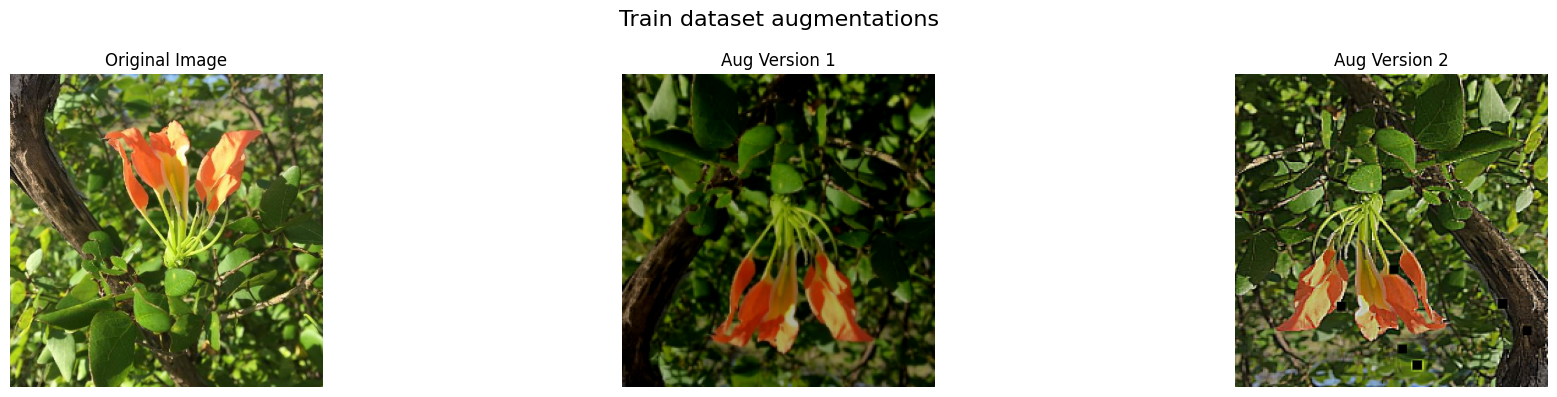

Feature                       Original       Aug Version 1  Aug Version 2  
WORLDCLIM_BI...               26.19          26.19          26.19          
WORLDCLIM_BI...               1509.79        1509.79        1509.79        
WORLDCLIM_BI...               427.92         427.92         427.92         
WORLDCLIM_BI...               120.31         120.31         120.31         
WORLDCLIM_BI...               160.38         160.38         160.38         


In [ ]:
#visualize_augmentations(dataset=train_dataset, title='Train dataset augmentations', idx=14, augment_times=2)

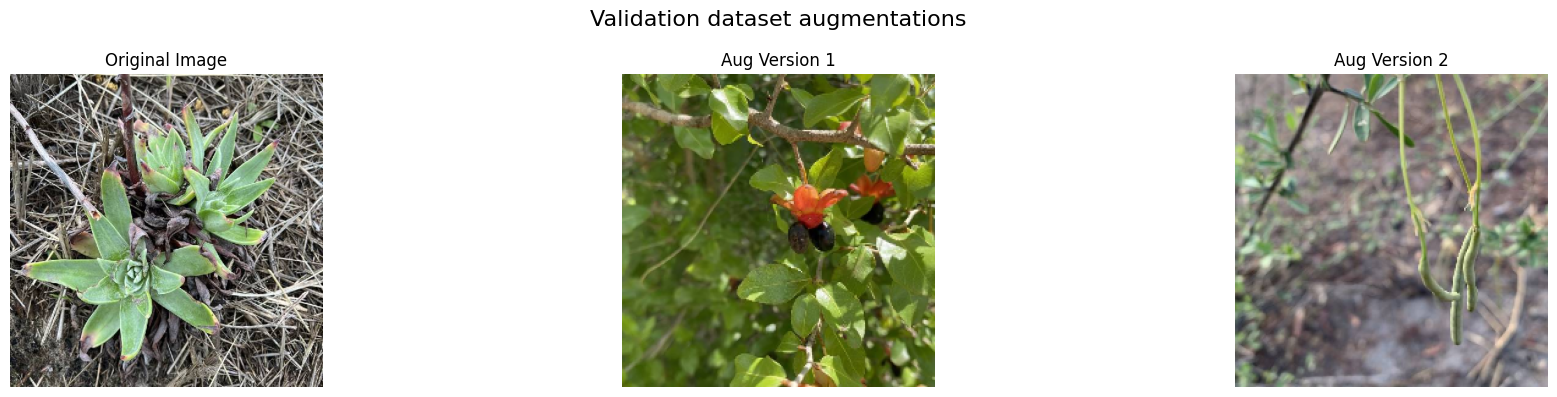

Feature                       Original       Aug Version 1  Aug Version 2  
WORLDCLIM_BI...               13.71          21.94          23.29          
WORLDCLIM_BI...               598.19         626.02         353.63         
WORLDCLIM_BI...               120.50         106.54         92.27          
WORLDCLIM_BI...               90.98          76.01          101.96         
WORLDCLIM_BI...               242.95         327.05         400.05         


In [ ]:
#visualize_augmentations(dataset=val_dataset, title='Validation dataset augmentations', idx=14, augment_times=2)

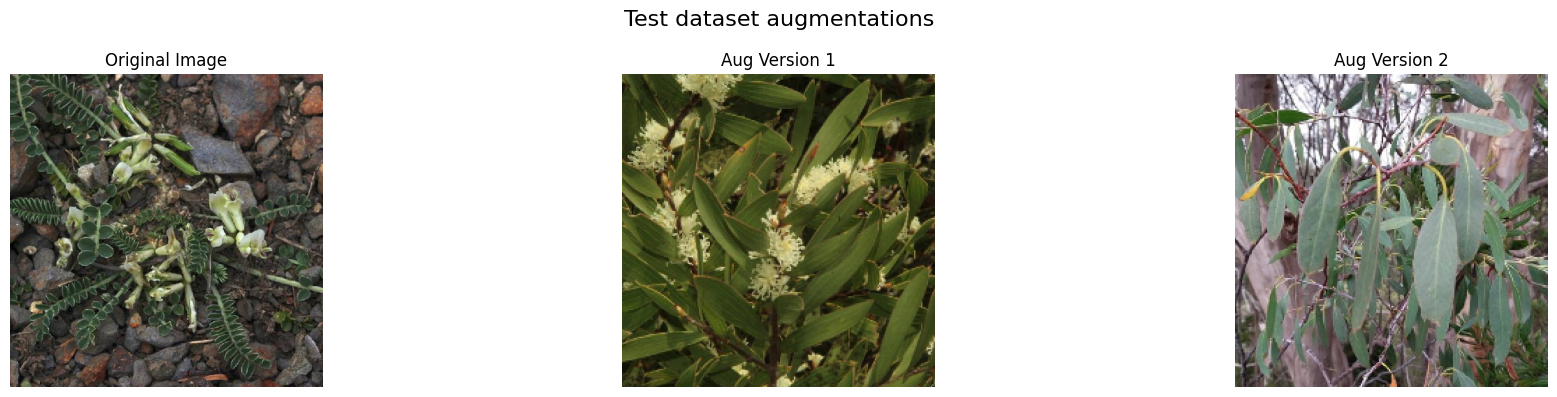

Feature                       Original       Aug Version 1  Aug Version 2  
WORLDCLIM_BI...               3.11           12.70          5.96           
WORLDCLIM_BI...               1440.20        644.07         1566.17        
WORLDCLIM_BI...               95.53          64.13          89.85          
WORLDCLIM_BI...               24.42          43.71          22.09          
WORLDCLIM_BI...               627.31         351.10         332.18         


In [ ]:
#visualize_augmentations(dataset=test_dataset, title='Test dataset augmentations', idx=14, augment_times=2)

#**Baselines**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

## Create dataloaders


In [ ]:
train_loader = DataLoader(train_dataset, batch_size= 16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)

In [ ]:
class PlantTraitsPretrainedVGG16(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.3, inplace=False),
           nn.Linear(in_features=4096, out_features=2048, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.3, inplace=False),
           nn.Linear(in_features=2048, out_features=6, bias=True),
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PlantTraitsPretrainedVGG16()
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.3MB/s]


PlantTraitsPretrainedVGG16(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

In [ ]:
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
from torchmetrics.regression import R2Score

In [ ]:
def r2_loss(output, target):
    target = target
    output = output
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return 1 - r2

In [ ]:
#Adatok GPU-ra való átmásolását végző függvény
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
from tqdm.notebook import tqdm #a progress bár esztétikus megjelenítésére

In [ ]:
def save_checkpoint(state, filename="/content/model_checkpoint.pth.tar"):
    torch.save(state, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(checkpoint_file, model, optimizer, scheduler, device):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch']

In [ ]:
class EarlyStoppingR2:
    def __init__(self, patience=10, delta=0, save=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.save = save

    def __call__(self, val_score, epoch, model, optimizer, scheduler):
        if self.best_score is None:
            self.best_score = val_score
            print(f"Best model loss: {val_score}")
            if self.save:
                checkpoint_filename = '/content/best_model.pth.tar'
                self.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                }, filename=checkpoint_filename)
        elif val_score < self.best_score - self.delta:
            self.counter += 1
            print(f"EarlyStopping patience counter: {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_score > self.best_score:
                self.best_score = val_score
                self.counter = 0
                print(f"Best model loss: {val_score}")
                if self.save:
                    checkpoint_filename = '/content/best_model.pth.tar'
                    self.save({
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                    }, filename=checkpoint_filename)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(model, train_loader, val_loader, criterion, max_lr, grad_clip=0, opt_func=torch.optim.Adam,  weight_decay=0, epochs=10,
          architecture_name= "CNN", dataset_ratio = 0.1, resume = False, checkpoint_path='/content/best_model.pth.tar', experiment_name="exp"):
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    r2_score_metrics = R2Score(num_outputs=6).to(device)
     # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,  steps_per_epoch=len(train_loader))
    early_stopping = EarlyStoppingR2(patience=3, save=save_checkpoint)

    wandb.init(
      # Set the project where this run will be logged
      project="Plant_traits",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=experiment_name,
      # Track hyperparameters and run metadata
      config={
        "max_learning_rate": max_lr,
        "architecture": architecture_name,
        "epochs": epochs,
        "weight_decay": weight_decay,
        "dataset_ratio" : dataset_ratio,
        "criterion" : criterion,
        "grad_clip" : grad_clip,
        "opt_func" : opt_func
      })

    start_epoch = 0
    if resume and checkpoint_path:
        start_epoch = load_checkpoint(checkpoint_path, model, optimizer, sched, device)

    best_loss = float('inf')
    for epoch in range(start_epoch, start_epoch + epochs):
        model.train()
        epoch_loss = 0
        lrs = []
        for images, meta_data, targets in tqdm(train_loader):


            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            if grad_clip:
               nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item() * images.size(0)
            lrs.append(get_lr(optimizer))
            sched.step()

        epoch_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

        model.eval()  # Set model to evaluation mode

        with torch.no_grad():
            epoch_val_loss = 0.0
            r2_epoch_score = 0.0
            for images, meta_data, targets in tqdm(val_loader):

                outputs = model(images)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * images.size(0)
                r2_epoch_score += r2_score_metrics(outputs, targets)

            epoch_val_loss = epoch_val_loss /len(val_loader)
            r2_score = r2_epoch_score / len(val_loader)


            print(f'Epoch {epoch + 1}/{epochs} Validation Loss: {epoch_val_loss:.4f}')
            print(f'Validation R2 Score: {r2_score}')
            wandb.log({"val_loss": epoch_val_loss, "loss": epoch_loss, "r2_score": r2_score})
            early_stopping(r2_score, epoch, model, optimizer, sched)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    # Mark the run as finished
    wandb.finish()

def test_model(model, criterion, test_loader):
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    r2_score_metrics = R2Score(num_outputs=6).to(device)
    r2_epoch_score = 0
    with torch.no_grad():
       for images, meta_data, targets in test_loader:
            outputs = model(images)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item() * images.size(0)
            r2_epoch_score += r2_score_metrics(outputs, targets)

    test_loss = epoch_loss / len(test_loader)
    r2_score = r2_epoch_score / len(val_loader)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Validation R2 Score: {r2_score}')


Train a
- ResNet (too slow)
- VGG
- Efficientnet

In [ ]:
epochs = 20
opt_func = torch.optim.SGD
loss_func =r2_loss #  nn.MSELoss()
max_lr = 0.006387
grad_clip = 0.07608
weight_decay =  0.00009996
dataset_ratio =1
architecture_name = "Vgg16"

In [ ]:
train(model, train_loader, val_loader, criterion = loss_func, max_lr = max_lr, grad_clip=grad_clip, opt_func=opt_func, weight_decay= weight_decay, epochs=epochs,
      architecture_name= architecture_name,dataset_ratio = dataset_ratio, experiment_name = "Vgg16" )

wandb: Currently logged in as: tugyibeatrix (beateam). Use `wandb login --relogin` to force relogin


  0%|          | 0/8324 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_model(model, r2_loss, val_loader)

Test Loss: 3.4380
Validation R2 Score: -0.08563786000013351


## Idáig futtasd --------------------------------

# Hyperopt

In [ ]:
def train(model, train_loader, val_loader, criterion, max_lr, opt_func, grad_clip=0, weight_decay=0, epochs=10,
          architecture_name="CNN", dataset_ratio=0.1, resume=False, checkpoint_path='/content/best_model.pth.tar', experiment_name="exp", trial=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters())
    r2_score_metrics = R2Score(num_outputs=6).to(device)
    sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    wandb.init(
        project="Plant_traits",
        name=experiment_name,
        config={
            "max_learning_rate": max_lr,
            "architecture": architecture_name,
            "epochs": epochs,
            "dataset_ratio": dataset_ratio,
            "criterion": criterion,
            "grad_clip": grad_clip,
            "optimizer": opt_func.__name__
        }
    )

    start_epoch = 0
    if resume and checkpoint_path:
        start_epoch = load_checkpoint(checkpoint_path, model, sched, device, optimizer)

    best_loss = float('inf')
    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        lrs = []

        for images, meta_data, targets in tqdm(train_loader):
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            sched.step()

            total_loss += loss.item() * images.size(0)
            lrs.append(get_lr(optimizer))

        epoch_loss = total_loss / len(train_loader)
        wandb.log({"epoch": epoch + 1, "loss": epoch_loss, "lr": lrs[-1]})

        model.eval()
        epoch_val_loss, r2_epoch_score = 0.0, 0.0
        with torch.no_grad():
            for images, meta_data, targets in tqdm(val_loader):
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * images.size(0)
                r2_epoch_score += r2_score_metrics(outputs, targets)

        epoch_val_loss /= len(val_loader)
        r2_score = r2_epoch_score / len(val_loader)

        wandb.log({"val_loss": epoch_val_loss, "loss": epoch_loss, "r2_score": r2_score})
        print(f'Epoch {epoch + 1}/{epochs} Validation Loss: {epoch_val_loss:.4f}')
        print(f'Validation R2 Score: {r2_score}')

        if trial:
            trial.report(epoch_val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    wandb.finish()
    return epoch_val_loss

In [ ]:
def objective(trial):
    max_lr = trial.suggest_float('max_lr', 1e-4, 1e-2)

    optimizer_choices = {'Adam': optim.Adam} #'SGD': optim.SGD
    optimizer_name = trial.suggest_categorical('optimizer', list(optimizer_choices.keys()))
    optimizer_class = optimizer_choices[optimizer_name]

    weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-4)
    grad_clip = trial.suggest_float('grad_clip', 0, 0.6)

    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.7, 1.0)
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, weight_decay=weight_decay)


    model = PlantTraitsPretrainedVisionTransformer()
    model = model.to(device)

    return train(model, train_loader, val_loader, r2_loss, max_lr, optimizer, grad_clip, weight_decay, epochs = 5, trial=trial, experiment_name='ViT - hyperopt - ADAM')

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=8)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-16 11:48:48,010] A new study created in memory with name: no-name-a1f149fb-006e-4dab-8c0e-d3050e00f2d0
wandb: Currently logged in as: tugyibeatrix (beateam). Use `wandb login --relogin` to force relogin


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.8905
Validation R2 Score: -0.2203444093465805


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 4.0439
Validation R2 Score: -1.2557979822158813


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: nan
Validation R2 Score: nan


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: nan
Validation R2 Score: nan


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: nan
Validation R2 Score: nan


[W 2024-04-16 12:24:16,328] Trial 0 failed with parameters: {'max_lr': 0.00958914561532001, 'optimizer': 'Adam', 'weight_decay': 7.834113062249061e-05, 'grad_clip': 0.182981819561139} because of the following error: The value nan is not acceptable.
[W 2024-04-16 12:24:16,329] Trial 0 failed with value nan.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 4.7252
Validation R2 Score: -0.6246317028999329


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.8644
Validation R2 Score: -0.39851537346839905


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 3.7863
Validation R2 Score: -0.1410282552242279


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 3.7899
Validation R2 Score: -0.1527881920337677


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 3.6319
Validation R2 Score: -0.09657064825296402


[I 2024-04-16 13:01:28,200] Trial 1 finished with value: 3.6318772414406575 and parameters: {'max_lr': 0.004553980787276698, 'optimizer': 'Adam', 'weight_decay': 2.797384978883736e-05, 'grad_clip': 0.3146195064748465}. Best is trial 1 with value: 3.6318772414406575.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.6336
Validation R2 Score: -0.40620899200439453


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.6907
Validation R2 Score: -0.17756783962249756


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 3.6015
Validation R2 Score: -0.15852849185466766


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 3.5655
Validation R2 Score: -0.12086649239063263


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 3.4954
Validation R2 Score: -0.07231342792510986


[I 2024-04-16 13:38:41,965] Trial 2 finished with value: 3.495367071959432 and parameters: {'max_lr': 0.0060189187149998925, 'optimizer': 'Adam', 'weight_decay': 3.620147699559095e-06, 'grad_clip': 0.25918453773542965}. Best is trial 2 with value: 3.495367071959432.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.7946
Validation R2 Score: -1.167921781539917


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.5954
Validation R2 Score: -0.14230459928512573


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 3.9663
Validation R2 Score: -0.17593322694301605


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 3.5361
Validation R2 Score: -0.07676081359386444


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 3.5105
Validation R2 Score: -0.07317256182432175


[I 2024-04-16 14:15:54,935] Trial 3 finished with value: 3.510513598439802 and parameters: {'max_lr': 0.0016720985450378112, 'optimizer': 'Adam', 'weight_decay': 8.084814954110452e-05, 'grad_clip': 0.3878244773794832}. Best is trial 2 with value: 3.495367071959432.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 2.9310
Validation R2 Score: -0.0349966399371624


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.0340
Validation R2 Score: 0.008376304991543293


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 3.0078
Validation R2 Score: -0.037153881043195724


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.7431
Validation R2 Score: 0.10064949840307236


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.6019
Validation R2 Score: 0.1355714648962021


[I 2024-04-16 14:53:29,971] Trial 4 finished with value: 2.6019162392216564 and parameters: {'max_lr': 0.00023046710389144069, 'optimizer': 'Adam', 'weight_decay': 4.4161380876216924e-05, 'grad_clip': 0.35231775669129944}. Best is trial 4 with value: 2.6019162392216564.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 4.3517
Validation R2 Score: -0.24643252789974213


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.5261
Validation R2 Score: -0.20827911794185638


  0%|          | 0/555 [00:00<?, ?it/s]

In [ ]:
def objective(trial):
    max_lr = trial.suggest_float('max_lr', 1e-4, 1e-2)

    optimizer_choices = {'Adam': optim.Adam,  'SGD': optim.SGD}
    optimizer_name = trial.suggest_categorical('optimizer', list(optimizer_choices.keys()))
    optimizer_class = optimizer_choices[optimizer_name]

    weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-4)
    grad_clip = trial.suggest_float('grad_clip', 0, 0.6)

    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.7, 1.0)
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, weight_decay=weight_decay)


    model = PlantTraitsPretrainedVisionTransformer()
    model = model.to(device)

    return train(model, train_loader, val_loader, r2_loss, max_lr, optimizer, grad_clip, weight_decay, epochs = 5, trial=trial, experiment_name='ViT - hyperopt')

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=8)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-16 06:04:21,717] A new study created in memory with name: no-name-ba7f248c-75a1-4a36-89e9-5e1b86fde641
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Currently logged in as: tugyibeatrix (beateam). Use `wandb login --relogin` to force relogin


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 2.7746
Validation R2 Score: 0.02474934048950672


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.7678
Validation R2 Score: 0.09366355091333389


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.5589
Validation R2 Score: 0.12773382663726807


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.4700
Validation R2 Score: 0.15755292773246765


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.4325
Validation R2 Score: 0.17391405999660492


[I 2024-04-16 06:41:35,086] Trial 0 finished with value: 2.4324877313665314 and parameters: {'max_lr': 0.006431024962403513, 'optimizer': 'SGD', 'weight_decay': 8.314509593204133e-05, 'grad_clip': 0.042650759786785716, 'momentum': 0.9418489276462152}. Best is trial 0 with value: 2.4324877313665314.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 2.9730
Validation R2 Score: -0.4207388460636139


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.6253
Validation R2 Score: -0.07950738817453384


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.5676
Validation R2 Score: 0.0032842427026480436


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.5356
Validation R2 Score: 0.038924362510442734


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.5050
Validation R2 Score: 0.04638658091425896


[I 2024-04-16 07:18:23,504] Trial 1 finished with value: 2.50495292463394 and parameters: {'max_lr': 0.0006427848272733263, 'optimizer': 'Adam', 'weight_decay': 3.8327793328913785e-06, 'grad_clip': 0.4007776070954885}. Best is trial 0 with value: 2.4324877313665314.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 2.7039
Validation R2 Score: 0.003925942350178957


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.7333
Validation R2 Score: 0.08886390924453735


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.5291
Validation R2 Score: 0.14210033416748047


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.4562
Validation R2 Score: 0.1409507691860199


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.3977
Validation R2 Score: 0.17277154326438904


[I 2024-04-16 07:55:20,286] Trial 2 finished with value: 2.3976950296164 and parameters: {'max_lr': 0.0075643296804749, 'optimizer': 'Adam', 'weight_decay': 4.911325719324435e-05, 'grad_clip': 0.13942072384146853}. Best is trial 2 with value: 2.3976950296164.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 2.9974
Validation R2 Score: 0.00863707810640335


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.6344
Validation R2 Score: 0.12339738011360168


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.5591
Validation R2 Score: 0.11856231838464737


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.4600
Validation R2 Score: 0.1584467887878418


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.4363
Validation R2 Score: 0.16345608234405518


[I 2024-04-16 08:32:36,716] Trial 3 finished with value: 2.436342186334607 and parameters: {'max_lr': 0.007530291613845147, 'optimizer': 'SGD', 'weight_decay': 5.333131674861401e-05, 'grad_clip': 0.5004306455011578, 'momentum': 0.8484943177926766}. Best is trial 2 with value: 2.3976950296164.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.3517
Validation R2 Score: -1.0492206811904907


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.8812
Validation R2 Score: -0.3433862328529358


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.7334
Validation R2 Score: -0.18190599977970123


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.6876
Validation R2 Score: -0.12076933681964874


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.6567
Validation R2 Score: -0.10336650162935257


[I 2024-04-16 09:09:49,039] Trial 4 finished with value: 2.6566512275872007 and parameters: {'max_lr': 0.0002145327791644292, 'optimizer': 'Adam', 'weight_decay': 7.622691070946422e-05, 'grad_clip': 0.3920578729450258}. Best is trial 2 with value: 2.3976950296164.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 2.8289
Validation R2 Score: -0.04341914504766464


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.6058
Validation R2 Score: 0.10019311308860779


  0%|          | 0/555 [00:00<?, ?it/s]

#1. Proba:

In [ ]:
def objective(trial):
    max_lr = trial.suggest_float('max_lr', 1e-4, 1e-2)

    optimizer_choices = {'Adam': optim.Adam,  'SGD': optim.SGD}
    optimizer_name = trial.suggest_categorical('optimizer', list(optimizer_choices.keys()))
    optimizer_class = optimizer_choices[optimizer_name]

    weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-4)
    grad_clip = trial.suggest_float('grad_clip', 0, 0.6)

    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.7, 1.0)
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = lambda params: optimizer_choices[optimizer_name](params, lr=max_lr, weight_decay=weight_decay)


    model = PlantTraitsPretrainedVisionTransformer()
    model = model.to(device)

    return train(model, train_loader, val_loader, r2_loss, max_lr, optimizer, grad_clip, weight_decay, epochs = 5, trial=trial, experiment_name='ViT - hyperopt')

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=8)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-15 21:01:14,174] A new study created in memory with name: no-name-fe87f8e6-83d8-4e73-8166-b243c2c569a5


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.4136
Validation R2 Score: -0.0352247916162014


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.4073
Validation R2 Score: -0.0838668942451477


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.8047
Validation R2 Score: 0.06269814819097519


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.6965
Validation R2 Score: 0.09496834129095078


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.5421
Validation R2 Score: 0.15268564224243164


[I 2024-04-15 21:39:44,828] Trial 0 finished with value: 2.5420612640499867 and parameters: {'max_lr': 0.03817879553381222, 'optimizer': 'Adam', 'weight_decay': 0.0004365342952802256, 'grad_clip': 0.20743198097304305}. Best is trial 0 with value: 2.5420612640499867.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.1735
Validation R2 Score: -0.084433913230896


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.8058
Validation R2 Score: 0.07044921815395355


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 3.0895
Validation R2 Score: -0.014961452223360538


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.7205
Validation R2 Score: 0.07878205180168152


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.5117
Validation R2 Score: 0.16022779047489166


[I 2024-04-15 22:19:05,816] Trial 1 finished with value: 2.5116775023735953 and parameters: {'max_lr': 0.027700874277558227, 'optimizer': 'SGD', 'weight_decay': 0.0008910134251815699, 'grad_clip': 0.700367530006026, 'momentum': 0.27475531748265936}. Best is trial 1 with value: 2.5116775023735953.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.6437
Validation R2 Score: -0.26677635312080383


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.0573
Validation R2 Score: -0.0057897865772247314


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.8756
Validation R2 Score: 0.07883983850479126


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.9694
Validation R2 Score: 0.03469201549887657


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.6312
Validation R2 Score: 0.1333402395248413


[I 2024-04-15 22:57:37,204] Trial 2 finished with value: 2.6311913466839667 and parameters: {'max_lr': 0.0794910911296043, 'optimizer': 'SGD', 'weight_decay': 2.2576323203751163e-06, 'grad_clip': 0.5377159698726891, 'momentum': 0.505832487476338}. Best is trial 1 with value: 2.5116775023735953.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.0801
Validation R2 Score: -0.06983957439661026


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 3.0238
Validation R2 Score: 0.024845311418175697


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.8440
Validation R2 Score: 0.05905783548951149


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.6754
Validation R2 Score: 0.12716072797775269


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.5611
Validation R2 Score: 0.14434358477592468


[I 2024-04-15 23:36:12,047] Trial 3 finished with value: 2.5610818580412436 and parameters: {'max_lr': 0.05223836787390145, 'optimizer': 'Adam', 'weight_decay': 0.0004508293147248915, 'grad_clip': 0.9847107599240961}. Best is trial 1 with value: 2.5116775023735953.
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/5 Validation Loss: 3.1096
Validation R2 Score: -0.005143755115568638


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/5 Validation Loss: 2.8284
Validation R2 Score: 0.07459022849798203


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/5 Validation Loss: 2.8548
Validation R2 Score: 0.03455594182014465


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/5 Validation Loss: 2.5918
Validation R2 Score: 0.13073447346687317


  0%|          | 0/555 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/5 Validation Loss: 2.5013
Validation R2 Score: 0.15790128707885742


[I 2024-04-16 00:15:33,070] Trial 4 finished with value: 2.5013350391119107 and parameters: {'max_lr': 0.02686653866193137, 'optimizer': 'SGD', 'weight_decay': 0.0006261871659442823, 'grad_clip': 0.6119716478862998, 'momentum': 0.9185932354903407}. Best is trial 4 with value: 2.5013350391119107.


Best trial:
  Value: 2.5013350391119107
  Params: 
    max_lr: 0.02686653866193137
    optimizer: SGD
    weight_decay: 0.0006261871659442823
    grad_clip: 0.6119716478862998
    momentum: 0.9185932354903407
